In [1]:
# Check out LWP and LWP Variance like Schemann et al., 2020:

##############################################################
# Read in data:

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/Notebooks/")
from Sc_module import convert_single_timestamp
plt.rc('font', size=12) 
plt.style.use('seaborn-poster')

outputdir = "/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/master_plots/02_LWP_stats/"

###################################

file2 = "/home/qwertz/obs_data_MA/iqq_foghat/22/sups_iqq_mwr00_l2_clwvi_p00_20180822000000.nc"
file4 = "/home/qwertz/obs_data_MA/iqq_foghat/23/sups_iqq_mwr00_l2_clwvi_p00_20180823000000.nc"
file_icon = "/home/qwertz/data_js_icon_22_23_August_2018/stat_IQQ_all-times.nc"
ds_icon = xr.open_dataset(file_icon)
lwp_icon = ds_icon["tqc"].isel(ncells=0)
ds_foghat_cloud22 = xr.open_dataset(file2, engine="netcdf4")
ds_foghat_cloud23 = xr.open_dataset(file4, engine="netcdf4")

################################################################

lwp_obs = xr.concat([ds_foghat_cloud22["clwvi"], ds_foghat_cloud23["clwvi"]], dim="time")
lwp_obs_err = xr.concat([ds_foghat_cloud22["clwvi_err"], ds_foghat_cloud23["clwvi_err"]], dim="time")
#####
# Entfernen von doppelten Zeitpunkten:
lwp_obs = lwp_obs.drop_duplicates("time")
lwp_obs_err = lwp_obs_err.drop_duplicates("time")


print(lwp_icon)
print(lwp_obs)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<xarray.DataArray 'tqc' (time: 313)> Size: 1kB
[313 values with dtype=float32]
Coordinates:
  * time     (time) float64 3kB 2.018e+07 2.018e+07 ... 2.018e+07 2.018e+07
    clon     float32 4B ...
    clat     float32 4B ...
Attributes:
    standard_name:  tqc
    long_name:      total column integrated cloud water
    units:          kg m-2
    param:          69.1.0
    CDI_grid_type:  unstructured
<xarray.DataArray 'clwvi' (time: 130425)> Size: 522kB
array([0.09051361, 0.09516334, 0.08515579, ..., 0.160822  , 0.15609951,
       0.1589958 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1MB 2018-08-22 ... 2018-08-23T23:59:59.000...
Attributes:
    units:          kg m-2
    standard_name:  atmosphere_mass_content_of_cloud_liquid_water_content
    comment:        These values denote the vertically integrated amount of c...


/usr/lib/python3/dist-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/lib/python3/dist-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


LWP correlation:  0.31223376473013326


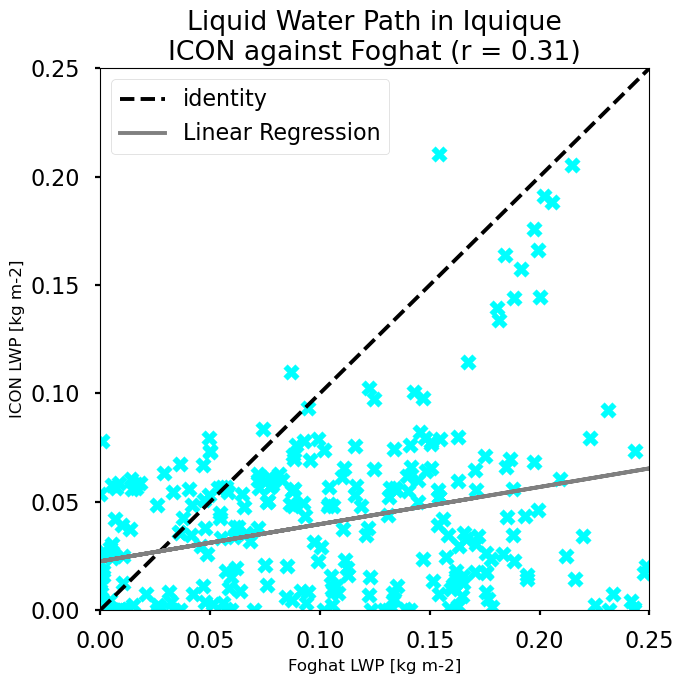

In [2]:
# Mache einen Scatterplot von beidem? gepaart nach t in IQQ?
# Berechne die dazugehörige Korrelation!

import sys
sys.path.append("/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/Notebooks/")
from Sc_module import convert_to_float_timestamps
from scipy.interpolate import interp1d

###############################################################################

def calculate_covariance(array_1, array_2):
    if len(array_1)!=len(array_2):
        print("Arrays haven’t got same dimensions: covariance calculation failed!")
        return 1
    mean_1 = np.nanmean(array_1)
    mean_2 = np.nanmean(array_2)
    summe = 0
    numel = 0
    for i in range(len(array_1)):
        if not(np.isnan(array_1[i]) or np.isnan(array_2[i])):
            summe = summe+(array_1[i]-mean_1)*(array_2[i]-mean_2)
            numel = numel+1
    covariance = summe/(numel-1)
    if np.isnan(covariance):
        covariance=0
    return covariance
    
###############################################################################
def calculate_regression_linear(array_1, array_2):
    #See that array_1 is the x-value for this regression...
    a = calculate_covariance(array_1, array_2)/calculate_covariance(\
    array_1, array_1)
    b = np.nanmean(array_2)-a*np.nanmean(array_1)
    regression_plot = np.zeros(len(array_1))
    for i in range(len(regression_plot)):
        regression_plot[i] = a * array_1[i] + b
    return regression_plot

###############################################################################

# Reduce ICON timeframe to two days:
reduced_icon = lwp_icon.sel(time=slice(20180822.0, 20180823.999))

# Interpolate observation on ICON timesteps:
float_times_obs = convert_to_float_timestamps(lwp_obs["time"].values)
interp_func = interp1d(float_times_obs, lwp_obs.values)
interpolated_lwp_obs = interp_func(reduced_icon["time"].values)

# Calculate correlation:
correlation_lwp = calculate_covariance(interpolated_lwp_obs, reduced_icon.values) /\
np.sqrt(calculate_covariance(interpolated_lwp_obs, interpolated_lwp_obs) * calculate_covariance(reduced_icon.values, reduced_icon.values))
print("LWP correlation: ", correlation_lwp)

###
# Scatter plot:
plt.figure(figsize=(7,7))
plt.title("Liquid Water Path in Iquique\nICON against Foghat (r = "+str(np.round(correlation_lwp,2))+")")
plt.scatter(interpolated_lwp_obs, reduced_icon.values, marker="X", color="cyan", linewidth=0.25)
plt.plot(range(2), range(2), color="black", linestyle="dashed", label="identity")
plt.plot(interpolated_lwp_obs, calculate_regression_linear(interpolated_lwp_obs, reduced_icon.values), color="grey",\
         label="Linear Regression")
plt.xlabel("Foghat LWP [kg m-2]", fontsize=12)       
plt.ylabel("ICON LWP [kg m-2]", fontsize=12) 
plt.xlim(0, 0.25)
plt.ylim(0,0.25)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(outputdir+"scatterplot_icon_foghat_corr.png")


In [3]:
# Mache das auch für 6-stündige Intervalle als Scatterplot! wie bei Schemann et al 2020:

def calculate_one_variance(begin_float=20180823.75, end_float=20180824.0, lwp_icon=lwp_icon, lwp_obs=lwp_obs):
    datetime_begin = str(convert_single_timestamp(begin_float))[:19]
    datetime_end = str(convert_single_timestamp(end_float))[:19]

    reduced_icon = lwp_icon.sel(time=slice(begin_float, end_float))
    reduced_obs = lwp_obs.sel(time=slice(datetime_begin, datetime_end))

    icon_variance = calculate_covariance(reduced_icon, reduced_icon)
    obs_variance = calculate_covariance(reduced_obs, reduced_obs)

    return icon_variance, obs_variance

################################################################################################

t_values = [20180822.0, 20180822.25, 20180822.5, 20180822.75, 20180823.0, 20180823.25, 20180823.5, 20180823.75,\
            20180824, 20180822.0,20180824]

icon_variances = []
obs_variances = []
plt.figure(figsize=(7,7))
print("Delete this decomment, to run this cell, which really runs long")
'''
for i, timestep in enumerate(t_values):
    if i+1==len(t_values):
        break
    if t_values[i+1]<timestep:
        print("overleaped timestep: ", timestep, " to ", t_values[i+1])
        continue
    begin_float = timestep
    end_float = t_values[i+1]
    icon_variance, obs_variance = calculate_one_variance(begin_float=begin_float, end_float=end_float)
    plt.scatter(icon_variance, obs_variance, marker="X", linewidth=0.5, label=str(timestep)+" to "+str(t_values[i+1]))
    print("Results for: ", timestep, " to ", t_values[i+1])
    icon_variances.append(icon_variance)
    obs_variances.append(obs_variance)


plt.plot(range(2), range(2), color="black", linestyle="dashed")
plt.xlim(0, 0.005)
plt.ylim(0,0.005)
plt.legend()
plt.savefig(outputdir+"scatterplot_variance_icon_foghat.png")
'''

Delete this decomment, to run this cell, which really runs long


'\nfor i, timestep in enumerate(t_values):\n    if i+1==len(t_values):\n        break\n    if t_values[i+1]<timestep:\n        print("overleaped timestep: ", timestep, " to ", t_values[i+1])\n        continue\n    begin_float = timestep\n    end_float = t_values[i+1]\n    icon_variance, obs_variance = calculate_one_variance(begin_float=begin_float, end_float=end_float)\n    plt.scatter(icon_variance, obs_variance, marker="X", linewidth=0.5, label=str(timestep)+" to "+str(t_values[i+1]))\n    print("Results for: ", timestep, " to ", t_values[i+1])\n    icon_variances.append(icon_variance)\n    obs_variances.append(obs_variance)\n\n\nplt.plot(range(2), range(2), color="black", linestyle="dashed")\nplt.xlim(0, 0.005)\nplt.ylim(0,0.005)\nplt.legend()\nplt.savefig(outputdir+"scatterplot_variance_icon_foghat.png")\n'

<Figure size 700x700 with 0 Axes>

overleaped timestep:  20180824  to  20180822.0


(0.0, 0.005)

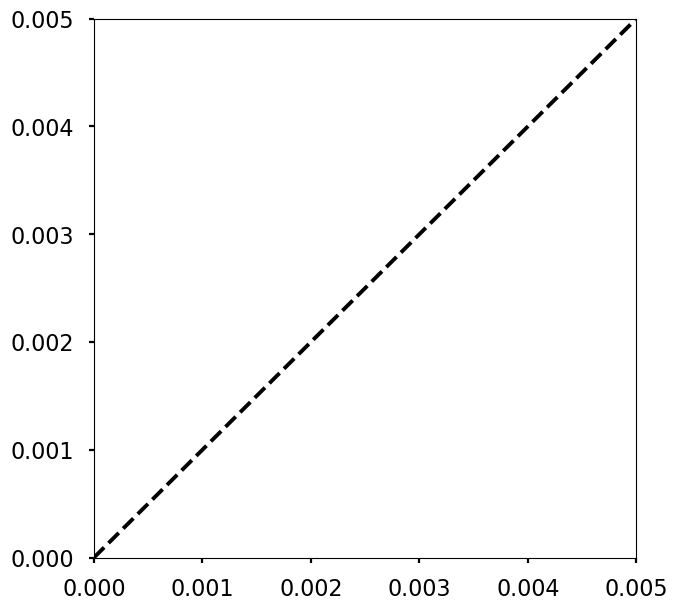

In [4]:
################################################################################################
# Plot:

plt.figure(figsize=(7,7))
for i, timestep in enumerate(t_values):
    if i+1==len(t_values):
        break
    if t_values[i+1]<timestep:
        print("overleaped timestep: ", timestep, " to ", t_values[i+1])
        continue
    else:
        plt.scatter(icon_variances, obs_variances, marker="X", linewidth=0.5, label=str(timestep)+" to "+str(t_values[i+1]))
plt.plot(range(2), range(2), color="black", linestyle="dashed")
plt.xlim(0, 0.005)
plt.ylim(0,0.005)
# plt.legend()

###########################
# Der Plot zeigt schon etwas:
# Die Variabilität in den Beobachtungen ist größer als in ICON
# aber es werden kaum die verschiedenen Zeitpunkte unterschieden.
# ferner ist 0.005 Varianz kein Wert der irgendwem was sagt...


In [5]:
# LWP Boxplot für MA:

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
sys.path.append("/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4/Thesis_prep_Juni_23/Porject_Work/")
from Sc_module import convert_single_timestamp
plt.rc('font', size=12) 
plt.style.use('seaborn-poster')

###################################

file2 = "/home/qwertz/obs_data_MA/iqq_foghat/22/sups_iqq_mwr00_l2_clwvi_p00_20180822000000.nc"
file3 = "/home/qwertz/obs_data_MA/iqq_foghat/22/sups_iqq_mwr00_l2_hua_p00_20180822000000.nc"
file4 = "/home/qwertz/obs_data_MA/iqq_foghat/23/sups_iqq_mwr00_l2_clwvi_p00_20180823000000.nc"
file5 = "/home/qwertz/obs_data_MA/iqq_foghat/23/sups_iqq_mwr00_l2_hua_p00_20180823000000.nc"
gridfile = "/home/qwertz/data_js_icon_22_23_August_2018/chile_square_0628m.nc"

ds_foghat_cloud22 = xr.open_dataset(file2, engine="netcdf4")
ds_foghat_hua22 = xr.open_dataset(file3, engine="netcdf4")
ds_foghat_cloud23 = xr.open_dataset(file4, engine="netcdf4")
ds_foghat_hua23 = xr.open_dataset(file5, engine="netcdf4")
gridds = xr.open_dataset(gridfile, engine="netcdf4")

#######################################

#####################################

lwp_obs = xr.concat([ds_foghat_cloud22["clwvi"], ds_foghat_cloud23["clwvi"]], dim="time")
lwp_obs_err = xr.concat([ds_foghat_cloud22["clwvi_err"], ds_foghat_cloud23["clwvi_err"]], dim="time")
#####
# Entfernen von doppelten Zeitpunkten:
lwp_obs = lwp_obs.drop_duplicates("time")
lwp_obs_err = lwp_obs_err.drop_duplicates("time")
# LWP als timeseries
# lwp_icon = xr.concat([ds_icon22["tqc"], ds_icon23["tqc"]], dim="time")

##########################################

def print_boxplots_of_LWP_time_vs_space(begin_float=20180822, end_float=20180822.25, outputdir=outputdir):
    datetime_begin = str(convert_single_timestamp(begin_float))[:19]
    datetime_end = str(convert_single_timestamp(end_float))[:19]

    # lwp_icon_plot = (lwp_icon.sel(time=slice(begin_float, end_float)).values[:, indices]).ravel()
    lwp_icon_plot = ds_icon["tqc"].sel(time=slice(begin_float, end_float)).isel(ncells=0).values
    lwp_obs_plot = lwp_obs.sel(time=slice(datetime_begin, datetime_end)).values
    foghat_median = np.median(lwp_obs_plot)
    icon_median =  np.median(lwp_icon_plot)
    
    plt.figure(figsize=(10,10))
    plt.title("Boxplot of Liquid Water Path at IQQ by Foghat and ICON\n\
        "+datetime_begin+" to "+datetime_end+"\n(Median of ICON: "+str(np.round(icon_median,3))+" ; Median of Foghat: "+\
              str(np.round(foghat_median, 3))+")")
    #plt.title("Boxplot of Liquid Water Path at IQQ by Foghat and ICON\n"+datetime_begin+" to "+datetime_end)
    lwp_data = {"Foghat":lwp_obs_plot, "ICON":lwp_icon_plot}
    sns.boxplot(data=lwp_data, palette=["blue", "red"])
    plt.ylabel("LWP [kg m-2]")
    plt.ylim(0,0.3)
    #plt.axhspan(0.10, 0.15, label="Typical Sc LWP range")
    #plt.legend()
    plt.tight_layout()
    plt.savefig(outputdir+datetime_begin+" to "+datetime_end+"_boxplot_LWP.png")
    plt.close()
    
    print("Zeitraum für LWP-Auswertung:")
    print("Anfangszeit:", datetime_begin)
    print("Endzeit:", datetime_end)
    print("LWP-Statistik für Foghat/MWR Daten:")
    print("Mittelwert:", np.mean(lwp_obs_plot))
    print("Median:", np.median(lwp_obs_plot))
    print("Standardabweichung:", np.std(lwp_obs_plot))
    print("LWP-Statistik für ICON LES Daten:")
    print("Mittelwert:", np.mean(lwp_icon_plot))
    print("Median:", np.median(lwp_icon_plot))
    print("Standardabweichung:", np.std(lwp_icon_plot))

#####################################

t_values = [20180822.0, 20180822.25, 20180822.5, 20180822.75, 20180823.0, 20180823.25, 20180823.5, 20180823.75, 20180824,\
            20180822.0, 20180824]

for i, timestep in enumerate(t_values):
    if i+1==len(t_values):
        break
    if t_values[i+1]<timestep:
        print("overleaped timestep: ", timestep, " to ", t_values[i+1])
        continue
    begin_float = timestep
    end_float = t_values[i+1]
    print_boxplots_of_LWP_time_vs_space(begin_float=begin_float, end_float=end_float)

######################################################

# Was ist die Logik hinter dem gewählten Radius?
# Sollte ich die Zeitspanne von Foghat in IQQ mit 6 h wirklich auch bei den ICON Daten verwenden?

Zeitraum für LWP-Auswertung:
Anfangszeit: 2018-08-22T00:00:00
Endzeit: 2018-08-22T06:00:00
LWP-Statistik für Foghat/MWR Daten:
Mittelwert: 0.08906746
Median: 0.08332105
Standardabweichung: 0.03986684
LWP-Statistik für ICON LES Daten:
Mittelwert: 0.043980706
Median: 0.048745878
Standardabweichung: 0.019808518
Zeitraum für LWP-Auswertung:
Anfangszeit: 2018-08-22T06:00:00
Endzeit: 2018-08-22T12:00:00
LWP-Statistik für Foghat/MWR Daten:
Mittelwert: 0.09734433
Median: 0.09753325
Standardabweichung: 0.032401457
LWP-Statistik für ICON LES Daten:
Mittelwert: 0.034226976
Median: 0.029003305
Standardabweichung: 0.024831077
Zeitraum für LWP-Auswertung:
Anfangszeit: 2018-08-22T12:00:00
Endzeit: 2018-08-22T18:00:00
LWP-Statistik für Foghat/MWR Daten:
Mittelwert: 0.014513238
Median: 0.0058876965
Standardabweichung: 0.022484036
LWP-Statistik für ICON LES Daten:
Mittelwert: 0.013070292
Median: 0.0
Standardabweichung: 0.018020742
Zeitraum für LWP-Auswertung:
Anfangszeit: 2018-08-22T18:00:00
Endzeit: 20

<xarray.Dataset> Size: 29MB
Dimensions:               (time: 2868, height: 592)
Coordinates:
  * time                  (time) datetime64[ns] 23kB 2018-08-22T00:01:15.0000...
  * height                (height) float32 2kB 202.2 222.2 ... 1.2e+04 1.202e+04
Data variables:
    latitude              float32 4B ...
    longitude             float32 4B ...
    altitude              float32 4B ...
    lwc                   (time, height) float32 7MB ...
    lwc_error             (time, height) float32 7MB ...
    lwc_retrieval_status  (time, height) int8 2MB ...
    lwp                   (time) float32 11kB ...
    lwp_error             (time) float32 11kB ...
    lwc_adiabatic         (time, height) float32 7MB ...
    lwc_th                (time, height) float32 7MB ...
Attributes:
    Conventions:  CF-1.0
    title:        Liquid water content from Iquique
    location:     Iquique
    day:          22
    month:        8
    year:         2018
    history:      24 Aug 2018 11:34:30 - Gene

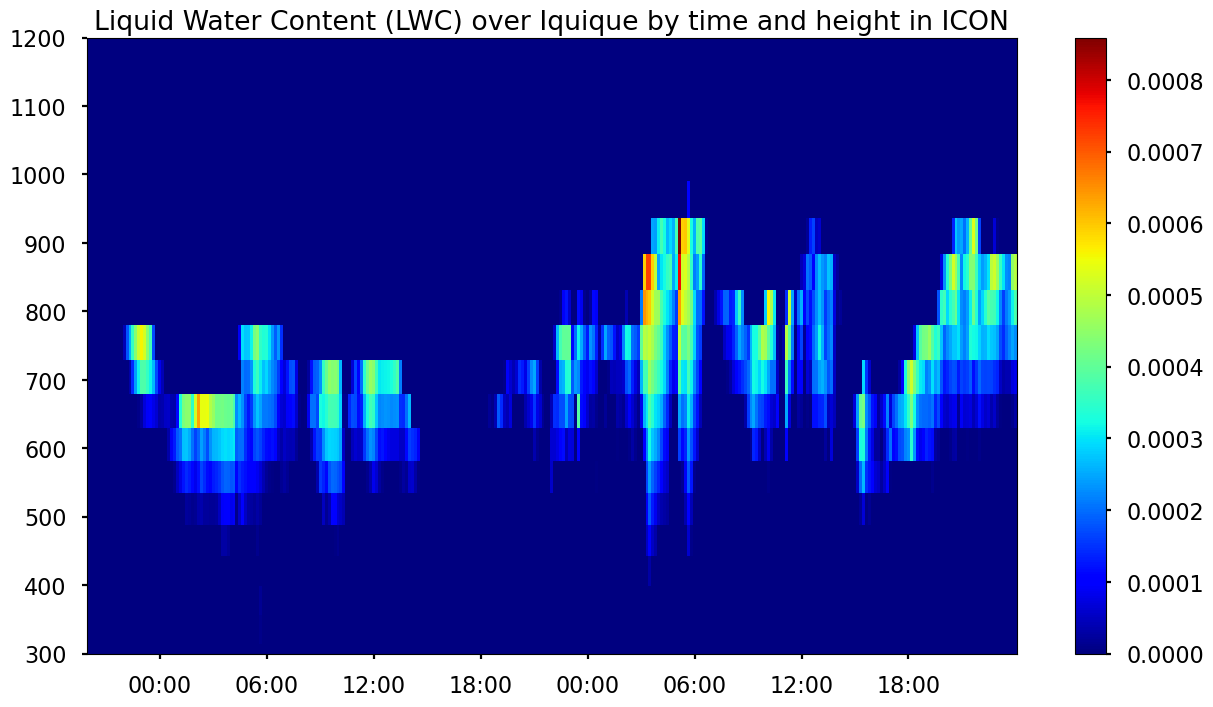

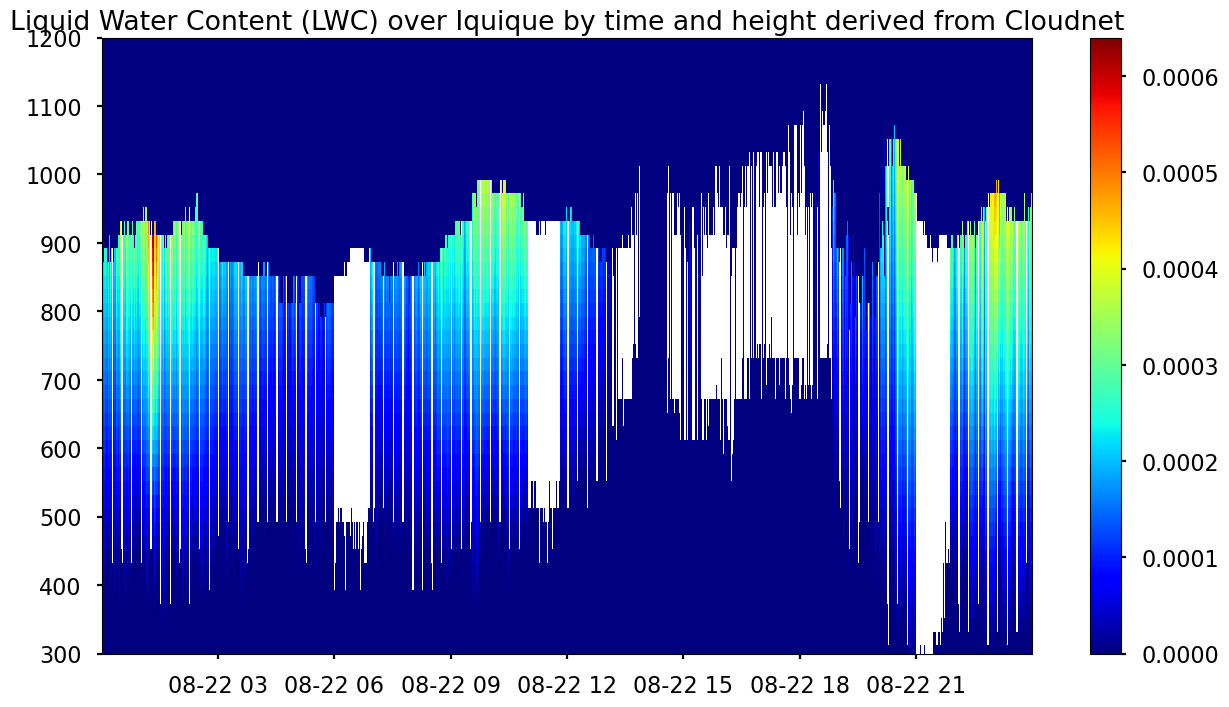

In [6]:
# LWC time x height plots:

#################################
# ICON LWC plot:
plt.figure(figsize=(15,8))
plt.title("Liquid Water Content (LWC) over Iquique by time and height in ICON")
plt.pcolormesh(ds_icon["time"], ds_icon["z_mc"], ds_icon["qc"].isel(ncells=0).values.T, cmap="jet")
# long_name:      specific cloud water content
#    units:          kg kg-1
plt.ylim(300,1200)
plt.colorbar()
plt.xticks(np.arange(20180822.0 , 20180824.0, 0.25),\
              ["00:00", "06:00", "12:00", "18:00", "00:00", "06:00", "12:00", "18:00"])

#################################
# Anything like that from measurement (?):
cloudnet_path = "/home/qwertz/obs_data_MA/iqq_cloudnet/"
lwc_file = "20180822_iquique_lwc-adiabatic-method.nc" 
ds_obs_lwc = xr.open_dataset(cloudnet_path+lwc_file)
print(ds_obs_lwc)
plt.figure(figsize=(15,8))
plt.title("Liquid Water Content (LWC) over Iquique by time and height derived from Cloudnet")
plt.pcolormesh(ds_obs_lwc["time"], ds_obs_lwc["height"], ds_obs_lwc["lwc"].values.T, cmap="jet")
plt.ylim(300,1200)
plt.colorbar()

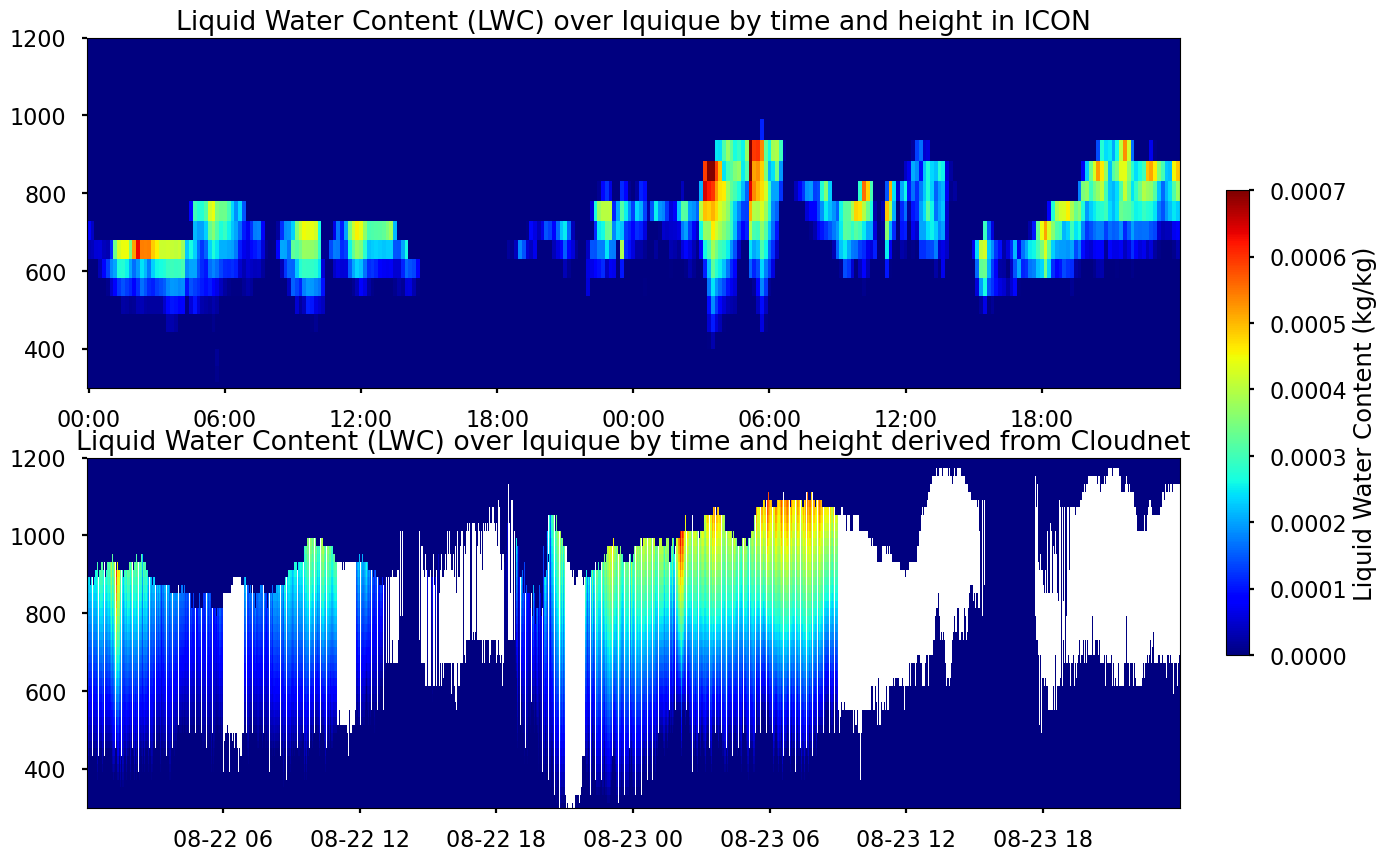

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

#################################
# ICON LWC and Measurement LWC in a Multi-plot with a shared colorbar:

controle = "/home/qwertz/UCLA/uclales/Runs/00_CONTROLE/"
# Load the datasets (assuming `ds_icon` is already loaded and `ds_obs_lwc` is as defined in your code)
cloudnet_path = "/home/qwertz/obs_data_MA/iqq_cloudnet/"
lwc_file1 = "20180822_iquique_lwc-adiabatic-method.nc" 
lwc_file2 = "20180823_iquique_lwc-adiabatic-method.nc" 
ds_obs_lwc22 = xr.open_dataset(cloudnet_path + lwc_file1)
ds_obs_lwc23 = xr.open_dataset(cloudnet_path + lwc_file2)
ds_obs_lwc = xr.concat([ds_obs_lwc22 , ds_obs_lwc23], dim="time")
controle_psds = xr.open_dataset(controle+"rf01.ps.nc")

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

# First plot: ICON LWC
axes[0].set_title("Liquid Water Content (LWC) over Iquique by time and height in ICON")
icon_plot = axes[0].pcolormesh(ds_icon["time"].sel(time=slice(20180822.0, 20180824.0)), ds_icon["z_mc"],\
                            ds_icon["qc"].isel(ncells=0).sel(time=slice(20180822.0, 20180824.0)).values.T, cmap="jet",\
                              vmin=0., vmax=0.0007)
axes[0].set_ylim(300, 1200)
axes[0].set_xticks(np.arange(20180822.0, 20180824.0, 0.25))
axes[0].set_xticklabels(["00:00", "06:00", "12:00", "18:00", "00:00", "06:00", "12:00", "18:00"])

# Second plot: Cloudnet LWC
axes[1].set_title("Liquid Water Content (LWC) over Iquique by time and height derived from Cloudnet")
obs_plot = axes[1].pcolormesh(ds_obs_lwc["time"], ds_obs_lwc["height"], ds_obs_lwc["lwc"].values.T, cmap="jet",\
                              vmin=0., vmax=0.0007)
axes[1].set_ylim(300, 1200)

# Create a single colorbar for both plots
cbar = fig.colorbar(icon_plot, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Liquid Water Content (kg/kg)')

# Show the multi-panel plot
# plt.tight_layout()  # Adjust layout for better spacing
# plt.show()
plt.savefig(outputdir+"LWC_ICON_and_Cloudnet.png")


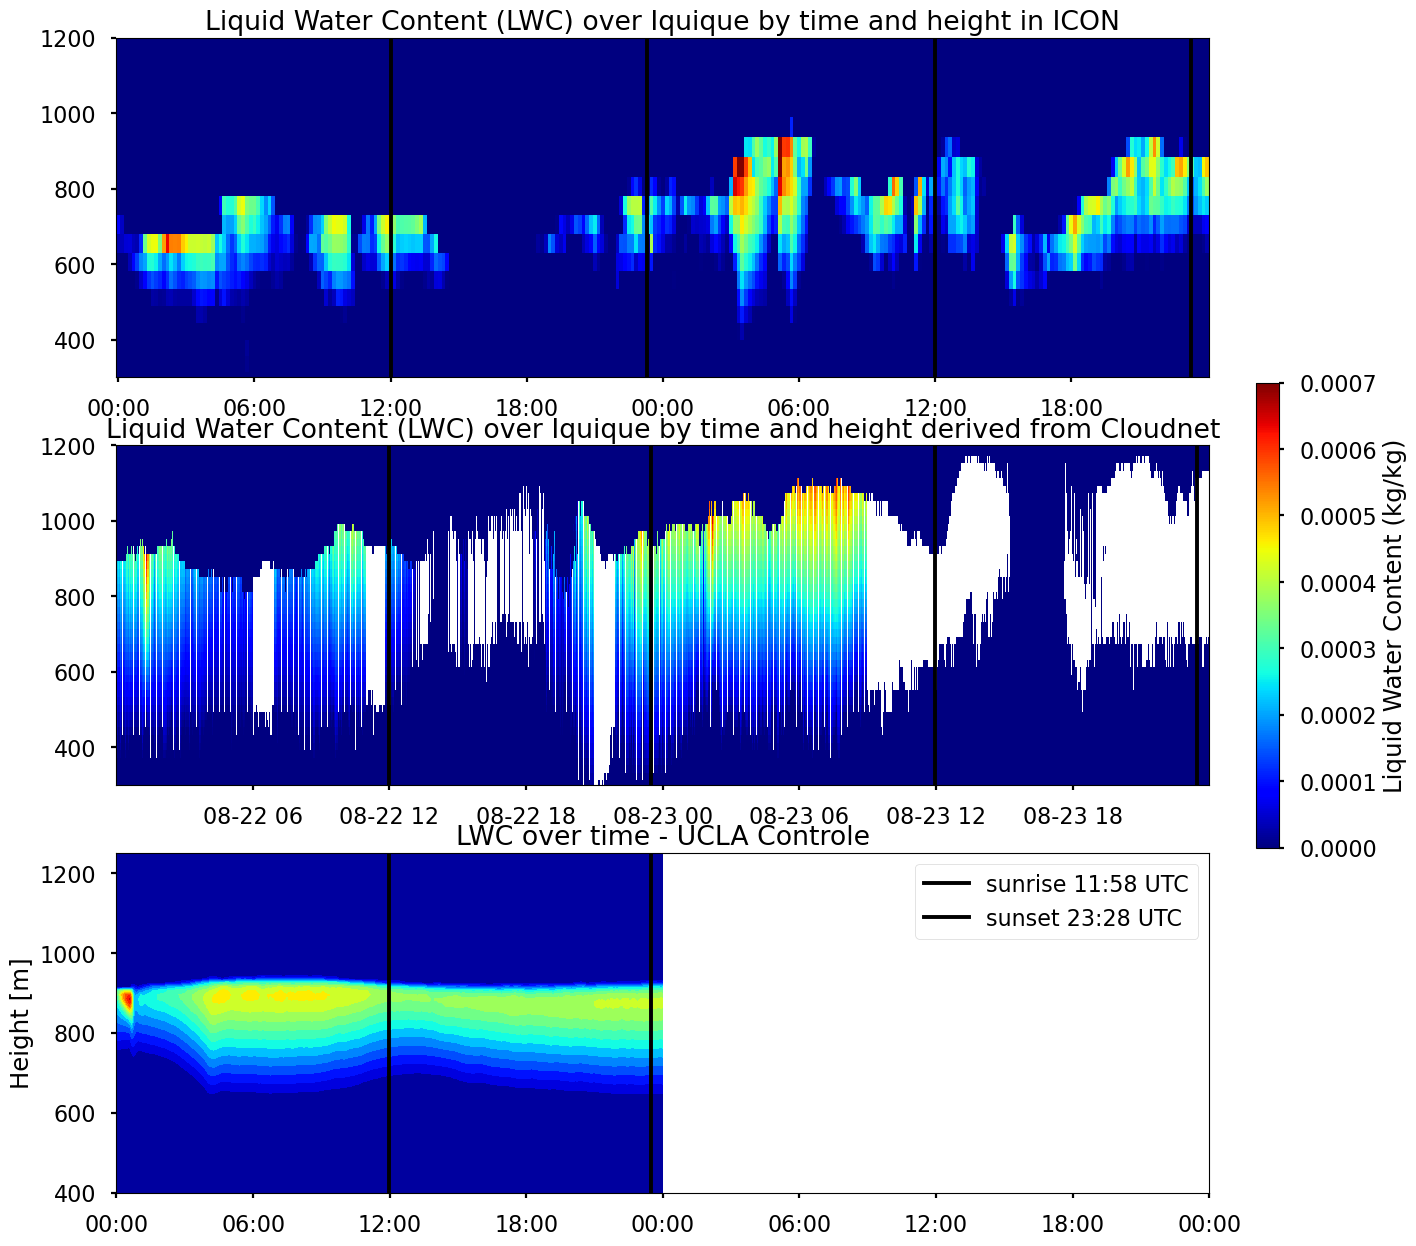

<Figure size 1280x880 with 0 Axes>

In [8]:
# With UCLA data:


import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H:%M')

########################################

def ucla_time2useful_time(ucla_time):
    # <class 'numpy.datetime64'> angeblich hat es bereits diesen Datentypen...
    time_list = []
    for i, timestep in enumerate(ucla_time):
        if i>2 and str(timestep)[10:19]=="T00:00:00":
            string = "2018-08-23"+str(timestep)[10:]
        else:
            string = "2018-08-22"+str(timestep)[10:]
        time_list.append(np.datetime64(string))
    new_time = np.array(time_list)
    return new_time

########################################

# Anpassung der Anzahl der Subplots auf 3 (3 Zeilen, 1 Spalte)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

# First plot: ICON LWC
axes[0].set_title("Liquid Water Content (LWC) over Iquique by time and height in ICON")
icon_plot = axes[0].pcolormesh(ds_icon["time"].sel(time=slice(20180822.0, 20180824.0)), ds_icon["z_mc"],
                            ds_icon["qc"].isel(ncells=0).sel(time=slice(20180822.0, 20180824.0)).values.T, cmap="jet",
                              vmin=0., vmax=0.0007)
axes[0].set_ylim(300, 1200)
axes[0].set_xticks(np.arange(20180822.0, 20180824.0, 0.25))
axes[0].set_xticklabels(["00:00", "06:00", "12:00", "18:00", "00:00", "06:00", "12:00", "18:00"])
axes[0].axvline(20180822.5, color="black",label="sunrise 11:58 UTC")
axes[0].axvline(20180822.97, color="black",label="sunset 23:28 UTC")
axes[0].axvline(20180823.5, color="black",label="sunrise 11:58 UTC")
axes[0].axvline(20180823.97, color="black",label="sunset 23:28 UTC")

# Second plot: Cloudnet LWC
axes[1].set_title("Liquid Water Content (LWC) over Iquique by time and height derived from Cloudnet")
obs_plot = axes[1].pcolormesh(ds_obs_lwc["time"], ds_obs_lwc["height"], ds_obs_lwc["lwc"].values.T, cmap="jet",
                              vmin=0., vmax=0.0007)
axes[1].set_ylim(300, 1200)
axes[1].axvline(np.datetime64("2018-08-22T11:58:00"), color="black",label="sunrise 11:58 UTC")
axes[1].axvline(np.datetime64("2018-08-22T23:28:00"), color="black",label="sunset 23:28 UTC")
axes[1].axvline(np.datetime64("2018-08-23T11:58:00"), color="black",label="sunrise 11:58 UTC")
axes[1].axvline(np.datetime64("2018-08-23T23:28:00"), color="black",label="sunset 23:28 UTC")

# Third plot: UCLA LWC (neuer Datensatz)
def plot_lwc_over_time(ax, ps_ds, name):
    ucla_times = ucla_time2useful_time(ps_ds["time"].values)
    c = ax.contourf(ucla_times, ps_ds["zt"], ps_ds["l"].T, levels=20, vmin=0, vmax=0.7, cmap="jet")
    ax.set_ylim(400, 1250)
    ax.set_xlim(np.datetime64("2018-08-22T00:00:00"), np.datetime64("2018-08-24T00:00:00"))
    ax.set_ylabel("Height [m]")
    ax.set_title("LWC over time - UCLA " + name)
    ax.xaxis.set_major_formatter(myFmt)
    ax.axvline(np.datetime64("2018-08-22T11:58:00"), color="black",label="sunrise 11:58 UTC")
    ax.axvline(np.datetime64("2018-08-22T23:28:00"), color="black",label="sunset 23:28 UTC")
    ax.legend()
    return c

# Plotting the third dataset in the third subplot
ucla_plot = plot_lwc_over_time(axes[2], controle_psds, "Controle")

# Create a single colorbar for all three plots
cbar = fig.colorbar(icon_plot, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Liquid Water Content (kg/kg)')

# Adjust layout to prevent overlap
# plt.tight_layout()

# Show plot
plt.show()

plt.savefig(outputdir+"LWC_ICON_and_Cloudnet_and_UCLA.png", facecolor="white")

In [9]:
# Berechne die LWP Varianz für Observations

# Berechne die LWP Varianz für ICON
